# Titanic - Machine Learning from Disaster

Predict survival on the Titanic and get familiar with ML basics.

This is my first submission of the famous _"Titanic"_ Kaggle's challenge. The objective is to to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc). 

I hope you enjoy reading this notebook.


## 1. Libraries

In [1]:
# Data Wrangling
#-----------------------------------------------------------------
import numpy as np
import pandas as pd

import pandas_profiling as pp

# Graphics
#-----------------------------------------------------------------
import matplotlib
%matplotlib inline 
#para que incruste la imagen en el notebook

import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing and modeling
#-----------------------------------------------------------------
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# Files management
#-----------------------------------------------------------------
import pickle


## 2. Uploading data and exploratory data analysis.

Kaggle has already split the original dataset on train and test datasets and let them available on csv files for us, so the only thing we must do to start the challenge is load them with pandas command _read_csv_.

In [2]:
train=pd.read_csv('train.csv')

Basic information of the dataframe.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [5]:
report = pp.ProfileReport(train)
report.to_file("report.html")
report

From that first step on data exploration we can assume there are no duplicate rows and two features with missing values, 'Age' and 'Cabin'. 

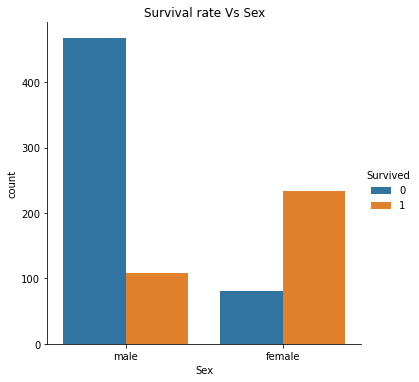

In [6]:
sns.catplot(data=train, 
            kind='count',
            x='Sex', 
            hue='Survived').set(title='Survival rate Vs Sex')

In [7]:
train['Rango_edad']=pd.cut(x=train['Age'], bins=16,retbins=False)

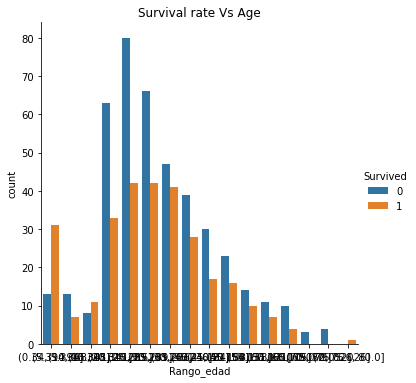

In [8]:
sns.catplot(data=train, 
            kind="count",
            x="Rango_edad", 
            hue="Survived" ).set(title='Survival rate Vs Age')

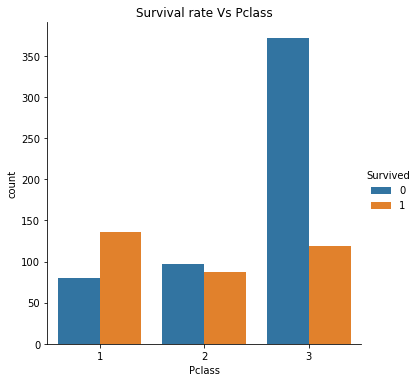

In [9]:
sns.catplot(data=train, 
            kind="count",
            x="Pclass", 
            hue="Survived" ).set(title='Survival rate Vs Pclass')

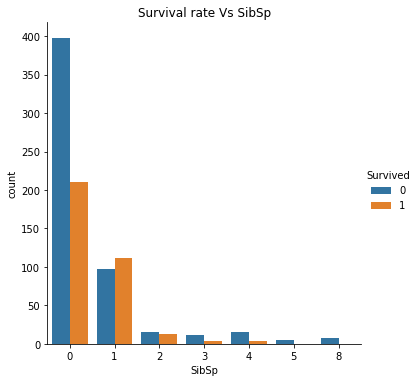

In [10]:
sns.catplot(data=train, 
            kind="count",
            x="SibSp", 
            hue="Survived" ).set(title='Survival rate Vs SibSp')

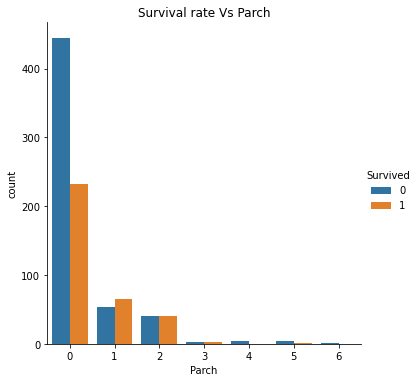

In [11]:
sns.catplot(data=train, 
            kind="count",
            x="Parch", 
            hue="Survived" ).set(title='Survival rate Vs Parch')

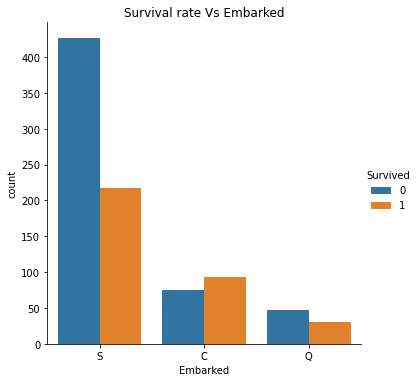

In [12]:
sns.catplot(data=train, 
            kind="count",
            x="Embarked", 
            hue="Survived" ).set(title='Survival rate Vs Embarked')

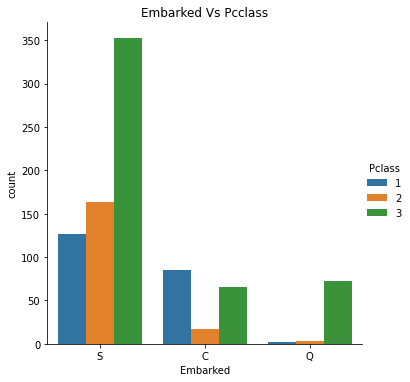

In [13]:
sns.catplot(data=train, 
            kind="count",
            x="Embarked", 
            hue="Pclass" ).set(title='Embarked Vs Pcclass')

Passengers by sex.

In [14]:
train['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

Passengers survival rate grouped by Sex and Class.

In [15]:
train.groupby(['Sex','Pclass'])['Survived'].value_counts(normalize=True)

Sex     Pclass  Survived
female  1       1           0.968085
                0           0.031915
        2       1           0.921053
                0           0.078947
        3       0           0.500000
                1           0.500000
male    1       0           0.631148
                1           0.368852
        2       0           0.842593
                1           0.157407
        3       0           0.864553
                1           0.135447
Name: Survived, dtype: float64

<AxesSubplot:>

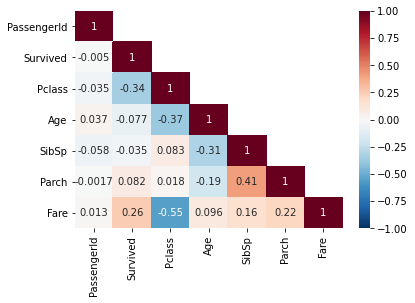

In [16]:
sns.heatmap(train.corr(),
           vmin=-1.0,
           vmax=1.0,
           annot=True,
           mask=np.tri(7,7,k=-1,dtype=bool).T,
           cmap='RdBu_r')

Trends:
1. Survival rate is higher when the Class is better. So first class travellers had more chances of survival than third class ones.

2. High dependency between survival and sex. Women had higher probability of survival than men.

3. Solo travellers have lower survival rates. Maybe most of them where men on third class journey.

4. Children younger than 10 years have better survival rates.

5. Young travellers tend to travell with more relatives (siblings and parents)

6. Higher ticket fares, better class and better survival rates.


### Missing Values

We found two features with missing values. 'Age' and 'Cabin'. We will use different approach for them:

- Age: Imputing the value with median and/or knn mean.

- Cabin: Don't use this feature as I think maybe this feature has no relevant information.




## 3. Modeling and trainning.

Transform categorical features, _Sex_ and _Embarked_ on numerical features with map method.

In [17]:
Sex_num={'female':1,'male':0}
train['Sex_num']=train['Sex'].map(Sex_num)

In [18]:
Embark={'C':0,'Q':1,'S':2}
train['Embarked_num']=train['Embarked'].map(Embark)

Selecting the features for the model.

In [19]:
y=train['Survived']
x=train[['Pclass','Sex_num','Age','SibSp','Parch','Fare','Embarked_num']]

In [20]:
x.head()

Pclass  Sex_num   Age  SibSp  Parch     Fare  Embarked_num
0       3        0  22.0      1      0   7.2500           2.0
1       1        1  38.0      1      0  71.2833           0.0
2       3        1  26.0      0      0   7.9250           2.0
3       1        1  35.0      1      0  53.1000           2.0
4       3        0  35.0      0      0   8.0500           2.0

### Setting grid search method for diferent model pipelines and their hyperparamters.

In [21]:

# Modelo 1. Regresión Logística -  Age imputing - median
#-----------------------------------------------------------------

PIPELINE_01=Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),
                            ('scaler',StandardScaler()),
                            ('lr',LogisticRegression())])

HIPERP_01={'scaler__with_mean': [True, False],
           'scaler__with_std': [True, False],
           'lr__C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
           'lr__fit_intercept': [True, False],
           'lr__class_weight': [None, 'balanced']}

GRID_01=GridSearchCV(PIPELINE_01,
                    HIPERP_01,
                    cv=10,
                    verbose=1,
                    scoring='accuracy',
                    n_jobs=-2)

In [22]:

# Modelo 11. Regresión Logística - Imputación de la edad - KNN media
#-----------------------------------------------------------------

PIPELINE_011=Pipeline(steps=[('imputer',KNNImputer()),
                            ('scaler',StandardScaler()),
                            ('lr',LogisticRegression())])

HIPERP_011={'imputer__n_neighbors':[3,5,7],
            'imputer__weights':['uniform','distance'],
            'scaler__with_mean': [True, False],
           'scaler__with_std': [True, False],
           'lr__C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
           'lr__fit_intercept': [True, False],
           'lr__class_weight': [None, 'balanced']}

GRID_011=GridSearchCV(PIPELINE_011,
                    HIPERP_011,
                    cv=10,
                    verbose=1,
                    scoring='accuracy',
                    n_jobs=-2)

In [23]:

# Modelo 2. KNN algoritmo - Imputación de la edad - mediana
#-----------------------------------------------------------------


PIPELINE_02=Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),
                            ('scaler',StandardScaler()),
                            ('knn',KNeighborsClassifier())])

HIPERP_02={'scaler__with_mean': [True, False],
           'scaler__with_std': [True, False],
           'knn__n_neighbors': [1,3,5,7,9,11,15,17,21,35],
           'knn__metric': ['minkowski', 'euclidean'],
           'knn__p': [1,2,3,4]}

GRID_02=GridSearchCV(PIPELINE_02,
                    HIPERP_02,
                    cv=10,
                    verbose=1,
                    scoring='accuracy',
                    n_jobs=-2)


In [24]:

# Modelo 3. Arbol de decisión - Imputación de la edad - mediana
#-----------------------------------------------------------------

PIPELINE_03=Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),
                            ('scaler',StandardScaler()),
                            ('dtc',DecisionTreeClassifier())])

HIPERP_03={'scaler__with_mean': [True, False],
           'scaler__with_std': [True, False],
           'dtc__max_depth': [2,3,4,5,6,9,15],
           'dtc__min_samples_split': [3,4,5,7],
           'dtc__min_samples_leaf': [3,4,5,7]}
          
GRID_03=GridSearchCV(PIPELINE_03,
                    HIPERP_03,
                    cv=10,
                    verbose=1,
                    scoring='accuracy',
                    n_jobs=-2)


In [25]:

# Modelo 4. Random Forest - Imputación de la edad - mediana
#-----------------------------------------------------------------


PIPELINE_04=Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),
                            ('scaler',StandardScaler()),
                            ('rfc',RandomForestClassifier())])

HIPERP_04={'scaler__with_mean': [True, False],
           'scaler__with_std': [True, False],
           'rfc__n_estimators': [10, 30, 50, 100, 200],
           'rfc__max_depth': [3,4,5,6],
           'rfc__min_samples_split': [3,4,5,10],
           'rfc__min_samples_leaf': [3,4,5,10]}
          
GRID_04=GridSearchCV(PIPELINE_04,
                    HIPERP_04,
                    cv=10,
                    verbose=1,
                    scoring='accuracy',
                    n_jobs=-2)


In [26]:

# Modelo 5. Support Vector Machine - Imputación de la edad - mediana
#-----------------------------------------------------------------

PIPELINE_05=Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),
                            ('scaler',StandardScaler()),
                            ('SVC',SVC())])

HIPERP_05={'scaler__with_mean': [True, False],
           'scaler__with_std': [True, False],
           'SVC__C': [0.01, 0.1, 0.5, 1.0, 2.0, 10.0],
           'SVC__kernel': ['poly','rbf'],
           'SVC__degree': [2,3,4],
           'SVC__class_weight': [None,'balanced']}        

GRID_05=GridSearchCV(PIPELINE_05,
                    HIPERP_05,
                    cv=10,
                    verbose=1,
                    scoring='accuracy',
                    n_jobs=-2)


In [27]:

# Modelo 6. Gradient Boost - Imputación de la edad - mediana
#-----------------------------------------------------------------

PIPELINE_06=Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),
                            ('scaler',StandardScaler()),
                            ('GBR',GradientBoostingClassifier())])

HIPERP_06={'scaler__with_mean': [True, False],
           'scaler__with_std': [True, False],
           'GBR__learning_rate': [0.05, 0.1, 0.5],
           'GBR__n_estimators': [50,100,150,250],
           'GBR__max_depth': [3,4,5,10],
           'GBR__subsample': [1.0, 0.75, 0.5],
           'GBR__max_features': [2,3,6]}
           
GRID_06=GridSearchCV(PIPELINE_06,
                    HIPERP_06,
                    cv=10,
                    verbose=1,
                    scoring='accuracy',
                    n_jobs=-2)


In [28]:

# Modelo 61. Gradient Boost - Age imputing - KNN
#-----------------------------------------------------------------

PIPELINE_061=Pipeline(steps=[('imputer',KNNImputer()),
                            ('scaler',StandardScaler()),
                            ('GBR',GradientBoostingClassifier())])

HIPERP_061={'imputer__n_neighbors':[3,5,7],
            'imputer__weights':['uniform','distance'],
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False],
            'GBR__learning_rate': [0.05, 0.1, 0.5],
            'GBR__n_estimators': [50,100,150],
            'GBR__max_depth': [3,4,5],
            'GBR__subsample': [1.0, 0.75, 0.5],
            'GBR__max_features': [2,3,6]}   
           
GRID_061=GridSearchCV(PIPELINE_061,
                    HIPERP_061,
                    cv=10,
                    verbose=1,
                    scoring='accuracy',
                    n_jobs=-2)


In [29]:

# Modelo 62. Gradient Boost - Age imputing - Knn /2nd Grid
#-----------------------------------------------------------------

PIPELINE_062=Pipeline(steps=[('imputer',KNNImputer()),
                            ('scaler',StandardScaler()),
                            ('GBR',GradientBoostingClassifier())])

HIPERP_062={'imputer__n_neighbors':[1,3,9],
            'imputer__weights':['distance'],
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False],
            'GBR__learning_rate': [0.05, 0.1, 0.5],
            'GBR__n_estimators': [25,50,75],
            'GBR__max_depth': [5,6,7],
            'GBR__subsample': [0.9, 0.75, 0.60],
            'GBR__max_features': [3,4]}
           
GRID_062=GridSearchCV(PIPELINE_062,
                    HIPERP_062,
                    cv=10,
                    verbose=1,
                    scoring='accuracy',
                    n_jobs=-2)


In [30]:

# Modelo 63. Gradient Boost - Age imputing - Knn / 3er grid
#-----------------------------------------------------------------

PIPELINE_063=Pipeline(steps=[('imputer',KNNImputer()),
                            ('GBR',GradientBoostingClassifier())])

HIPERP_063={'imputer__n_neighbors':[3,9,11],
            'imputer__weights':['distance'],
            'GBR__learning_rate': [0.025, 0.05, 0.075],
            'GBR__n_estimators': [60,75,90],
            'GBR__max_depth': [5,6,7],
            'GBR__subsample': [0.8, 0.75, 0.60],
            'GBR__max_features': [3,4]
            }
           
GRID_063=GridSearchCV(PIPELINE_063,
                    HIPERP_063,
                    cv=10,
                    verbose=1,
                    scoring='accuracy',
                    n_jobs=-2)


### Trainning models

In [31]:
# Modelo 1
GRID_01.fit(x,y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 960 out of 960 | elapsed:    4.8s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-2,
             param_grid={'lr__C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
                         'lr__class_weight': [None, 'balanced'],
                         'lr__fit_intercept': [True, False],
                         'scaler__with_mean': [True, False],
                         'scaler__with_std': [True, False]},
             scoring='accuracy', verbose=1)

In [32]:
GRID_01.best_score_

0.8024968789013732

In [33]:
GRID_01.best_params_

{'lr__C': 0.01,
 'lr__class_weight': None,
 'lr__fit_intercept': True,
 'scaler__with_mean': True,
 'scaler__with_std': True}

In [34]:
# Modelo 011
GRID_011.fit(x,y)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 1250 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-2)]: Done 3250 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-2)]: Done 5760 out of 5760 | elapsed:   43.4s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('scaler', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-2,
             param_grid={'imputer__n_neighbors': [3, 5, 7],
                         'imputer__weights': ['uniform', 'distance'],
                         'lr__C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
                         'lr__class_weight': [None, 'balanced'],
                         'lr__fit_intercept': [True, False],
                         'scaler__with_mean': [True, False],
                         'scaler__with_std': [True, False]},
             scoring='accuracy', verbose=1)

In [35]:
GRID_011.best_score_

0.8036204744069912

In [36]:
GRID_011.best_params_

{'imputer__n_neighbors': 5,
 'imputer__weights': 'uniform',
 'lr__C': 0.01,
 'lr__class_weight': None,
 'lr__fit_intercept': True,
 'scaler__with_mean': True,
 'scaler__with_std': True}

In [37]:
# Modelo 2
GRID_02.fit(x,y)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Fitting 10 folds for each of 320 candidates, totalling 3200 fits


[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 1250 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-2)]: Done 3180 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-2)]: Done 3200 out of 3200 | elapsed:   11.8s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-2,
             param_grid={'knn__metric': ['minkowski', 'euclidean'],
                         'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 17, 21,
                                              35],
                         'knn__p': [1, 2, 3, 4],
                         'scaler__with_mean': [True, False],
                         'scaler__with_std': [True, False]},
             scoring='accuracy', verbose=1)

In [38]:
GRID_02.best_score_

0.8294382022471911

In [39]:
GRID_02.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=15, p=1))])

In [40]:
# Modelo 3
GRID_03.fit(x,y)
GRID_03.best_score_

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Fitting 10 folds for each of 448 candidates, totalling 4480 fits


[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 2290 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-2)]: Done 4480 out of 4480 | elapsed:   10.7s finished


0.8373533083645442

In [41]:
GRID_03.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler(with_mean=False)),
                ('dtc',
                 DecisionTreeClassifier(max_depth=9, min_samples_leaf=5,
                                        min_samples_split=4))])

In [42]:
# Modelo 4
GRID_04.fit(x,y)
GRID_04.best_score_

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Fitting 10 folds for each of 1280 candidates, totalling 12800 fits


[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 347 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-2)]: Done 811 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-2)]: Done 1362 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-2)]: Done 2024 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 2844 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 3766 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-2)]: Done 4836 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-2)]: Done 6112 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-2)]: Done 7597 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-2)]: Done 9062 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-2)]: Done 10655 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-2)]: Done 12612 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-2)]: Done 12800 out of 12800 | elapsed:  7.6min finished


0.8372908863920101

In [43]:
GRID_04.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=3,
                                        min_samples_split=5,
                                        n_estimators=30))])

In [44]:
# Modelo 5
GRID_05.fit(x,y)
GRID_05.best_score_

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 1250 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-2)]: Done 2783 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-2)]: Done 2867 out of 2880 | elapsed:   28.9s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 2880 out of 2880 | elapsed:   29.1s finished


0.826067415730337

In [45]:
GRID_05.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler(with_mean=False)),
                ('SVC', SVC(C=2.0, degree=2))])

In [46]:
# Modelo 6
GRID_06.fit(x,y)
GRID_06.best_score_

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 358 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-2)]: Done 858 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-2)]: Done 1558 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-2)]: Done 2174 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 2724 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 3374 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done 4124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-2)]: Done 4974 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-2)]: Done 5924 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-2)]: Done 7408 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-2)]: Done 8558 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-2)]: Done 9808 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-2)]: Done 11158 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-2)]: Done 13497 tasks     

0.8451560549313358

In [47]:
GRID_06.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler(with_mean=False)),
                ('GBR',
                 GradientBoostingClassifier(max_depth=5, max_features=6,
                                            n_estimators=50, subsample=0.75))])

In [48]:
GRID_061.fit(x,y)
GRID_061.best_score_

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Fitting 10 folds for each of 5832 candidates, totalling 58320 fits


[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 358 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-2)]: Done 858 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-2)]: Done 1558 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-2)]: Done 2458 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 3558 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 4858 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done 6358 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-2)]: Done 8058 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-2)]: Done 9958 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-2)]: Done 11237 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-2)]: Done 12387 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-2)]: Done 13637 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-2)]: Done 14987 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-2)]: Done 16437 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-2)]: Done 17987 tasks      | elapse

0.8473782771535581

In [49]:
GRID_061.best_estimator_

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=7)),
                ('scaler', StandardScaler()),
                ('GBR',
                 GradientBoostingClassifier(max_depth=5, max_features=3,
                                            subsample=0.75))])

In [50]:
GRID_062.fit(x,y)

Fitting 10 folds for each of 1944 candidates, totalling 19440 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done 358 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-2)]: Done 858 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-2)]: Done 1558 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 2458 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 3242 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-2)]: Done 3892 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-2)]: Done 4642 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-2)]: Done 5492 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-2)]: Done 6442 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-2)]: Done 7492 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-2)]: Done 8642 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-2)]: Done 9892 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-2)]: Done 11242 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-2)]: Done 12692 tasks     

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('scaler', StandardScaler()),
                                       ('GBR', GradientBoostingClassifier())]),
             n_jobs=-2,
             param_grid={'GBR__learning_rate': [0.05, 0.1, 0.5],
                         'GBR__max_depth': [5, 6, 7],
                         'GBR__max_features': [3, 4],
                         'GBR__n_estimators': [25, 50, 75],
                         'GBR__subsample': [0.9, 0.75, 0.6],
                         'imputer__n_neighbors': [1, 3, 9],
                         'imputer__weights': ['distance'],
                         'scaler__with_mean': [True, False],
                         'scaler__with_std': [True, False]},
             scoring='accuracy', verbose=1)

In [51]:
GRID_062.best_score_

0.8530212234706618

In [52]:
GRID_062.best_estimator_

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3, weights='distance')),
                ('scaler', StandardScaler(with_mean=False, with_std=False)),
                ('GBR',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=6,
                                            max_features=4, n_estimators=75,
                                            subsample=0.75))])

In [53]:
GRID_063.fit(x,y)
GRID_063.best_score_

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-2)]: Done 1236 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 1786 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-2)]: Done 2436 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-2)]: Done 3186 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-2)]: Done 4036 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-2)]: Done 4860 out of 4860 | elapsed:  7.1min finished


0.8496629213483147

In [54]:
GRID_063.best_estimator_

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3, weights='distance')),
                ('GBR',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=6,
                                            max_features=4, n_estimators=60,
                                            subsample=0.8))])

### Results

In [55]:
#Dictionary with models and their performance

MODELOS={'Logistic regression':[GRID_01.best_score_,GRID_01.best_estimator_],
         'Logistic regression / KNN imputer':[GRID_011.best_score_,GRID_011.best_estimator_],
        'KNN':[GRID_02.best_score_,GRID_02.best_estimator_],
        'Decission Tree Classifier':[GRID_03.best_score_,GRID_03.best_estimator_],
        'Random forest Classifier': [GRID_04.best_score_,GRID_04.best_estimator_],
        'Support vector machine':[GRID_05.best_score_,GRID_05.best_estimator_],
        'Gradient Boosting':[GRID_06.best_score_,GRID_06.best_estimator_],
        'Gradient Boosting 01/ KNN imputer':[GRID_061.best_score_,GRID_061.best_estimator_],
        'Gradient Boosting 02/ KNN imputer':[GRID_062.best_score_,GRID_062.best_estimator_],
        'Gradient Boosting 03/ KNN imputer':[GRID_063.best_score_,GRID_063.best_estimator_],}

resumen=pd.DataFrame.from_dict(MODELOS, orient='index').rename(columns={0:'Accuracy',1:'Estimator'})
resumen.sort_values('Accuracy',ascending=False)


Accuracy  \
Gradient Boosting 02/ KNN imputer  0.853021   
Gradient Boosting 03/ KNN imputer  0.849663   
Gradient Boosting 01/ KNN imputer  0.847378   
Gradient Boosting                  0.845156   
Decission Tree Classifier          0.837353   
Random forest Classifier           0.837291   
KNN                                0.829438   
Support vector machine             0.826067   
Logistic regression / KNN imputer  0.803620   
Logistic regression                0.802497   

                                                                           Estimator  
Gradient Boosting 02/ KNN imputer  (KNNImputer(n_neighbors=3, weights='distance')...  
Gradient Boosting 03/ KNN imputer  (KNNImputer(n_neighbors=3, weights='distance')...  
Gradient Boosting 01/ KNN imputer  (KNNImputer(n_neighbors=7), StandardScaler(), ...  
Gradient Boosting                  (SimpleImputer(strategy='median'), StandardSca...  
Decission Tree Classifier          (SimpleImputer(strategy='median'), StandardSca...  
Random forest Classifier           (SimpleImputer(strategy='median'), StandardSca...  
KNN                                (SimpleImputer(strategy='median'), StandardSca...  
Support vector machine             (SimpleImputer(strategy='median'), StandardSca...  
Logistic regression / KNN imputer  (KNNImputer(), StandardScaler(), LogisticRegre...  
Logistic regression                (SimpleImputer(strategy='median'), StandardSca...

In [56]:
print('Best trained model is:\n\n', resumen[resumen['Accuracy']==resumen['Accuracy'].max()].iloc[0][1],'\n', 
      ' \n with Accuracy of: ', resumen.loc[resumen['Accuracy']==resumen['Accuracy'].max()].iloc[0][0])

Best trained model is:

 Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3, weights='distance')),
                ('scaler', StandardScaler(with_mean=False, with_std=False)),
                ('GBR',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=6,
                                            max_features=4, n_estimators=75,
                                            subsample=0.75))]) 
  
 with Accuracy of:  0.8530212234706618


In [57]:
# Model

estimador=GRID_062.best_estimator_

In [58]:
estimador.fit(x,y)

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3, weights='distance')),
                ('scaler', StandardScaler(with_mean=False, with_std=False)),
                ('GBR',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=6,
                                            max_features=4, n_estimators=75,
                                            subsample=0.75))])

In [59]:
# Save the model on a file

with open('survival_classifier.model','wb') as archivo:
        pickle.dump(estimador,archivo)


## 4. Predicting survival on test data with our chosen model.

Next, I will load test dataset and apply same transformations we took on our trainning model.

In [60]:
test=pd.read_csv('test.csv')

In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [62]:
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [63]:
# Map to asign numeric values.

Sex_num={'female':1,'male':0}
test['Sex_num']=test['Sex'].map(Sex_num)

Embark={'C':0,'Q':1,'S':2}
test['Embarked_num']=test['Embarked'].map(Embark)

In [64]:
x_test=test[['Pclass','Sex_num','Age','SibSp','Parch','Fare','Embarked_num']]

In [65]:
y_pred=estimador.predict(x_test)

In [66]:
# Add prdeictions column to test dayaset

test['Survived']=y_pred

In [67]:
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  Sex_num  Embarked_num  \
0  34.5      0      0   330911   7.8292   NaN        Q        0             1   
1  47.0      1      0   363272   7.0000   NaN        S        1             2   
2  62.0      0      0   240276   9.6875   NaN        Q        0             1   
3  27.0      0      0   315154   8.6625   NaN        S        0             2   
4  22.0      1      1  3101298  12.2875   NaN        S        1             2   

   Survived  
0         0  
1         0  
2         0  
3         0  
4         1

Create csv file with predictions.

In [68]:
test.to_csv('predictions.csv',columns=['PassengerId','Survived'], index=False)

Once upload the file the score on kaggle's leadersboard is 0.78468 